In [1]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt



In [2]:
# define constants and variables

# =============================constants=================

pi = np.pi

D = 2  # 浮标直径
r = 0.5 * D  # 浮标半径
v = 12 # ! 风速
H = 18 # ! 海平面高度

rho = 1025 # 海水密度
rho钢 = 7850 # 钢材密度
g = 9.81 # 重力加速度

m钢管 = 10 # 钢管的质量
m钢桶 = 100 # 钢桶的质量
m球  = 1200 # ! 求的质量

L链 = 20.05 #! 锚链总长度
l = 105 * 10**(-3) #! 锚链单个链环的长度
delta = 7 # 锚链线密度
nMax = np.int64(  np.floor( L链 / l ) )# 锚链的数量

# 每个物体收到的浮力和重力
class mList : 
    """自定义列表类，并不存储数据，只通过getitem方法返回对应的值"""
    def __init__(self, getitem: callable):
        self.getitem = getitem
    
    def __getitem__(self, index):
        return self.getitem(index)
# 各部分的重力
def G_func(index):
    if 0 <= index < 4: # [0, 1, 2, 3] => 逻辑位序 [ 1, 2, 3, 4 ] 
        return m钢管 * g
    elif index ==  4: # * 4 => 钢桶
        return m钢桶 * g
    else: # * 锚链
        return delta * l * g

G = mList(G_func)

def F浮_func(index):
    if 0 <= index < 4: # 钢管 d=0.05m h=1m
        return (0.05 / 2)**2 * pi * 1 * rho * g
    elif index == 4: # 钢桶 d=0.3m h=1m
        return ( 0.3 / 2)**2 * pi * 1 * rho * g
    else: # 锚链 
        return l*delta / rho钢 * rho * g
    
F浮 = mList(F浮_func)

def L_func(index):
    if 0 <= index < 4: # 钢管
        return 1
    elif index == 4: # 钢桶
        return 1
    else: # 锚链
        return l

L = mList(L_func)

# =======================================

# ! 各部分的受力情况
# 定义变量

# h = sp.Symbol('h')  # 浮标吃水深度

def H(h):
    Tcos = []
    Tsin = []

    # ? [0, 1, 2, 3] => 逻辑位序 [ 1, 2, 3, 4 ]  钢管
    # ? 4 => 5 桶
    # ? [5, ..., nMax+5-1] => 锚链

    # ? i = 0 => 第一段钢管
    Tcos.append( 0.625 * D * (2 - h) * v**2 )
    Tsin.append( rho * g * pi * r**2 * h )
    #? [1, 2, 3, 4] => 钢管和桶
    for i in range(1, 5): 
        # ! Tcos[i+1] = Tcos[i] 
        Tcos.append( Tcos[i-1] )
        # ! Tsin[i+1] = Tsin[i] - G[i] + F浮[i]
        Tsin.append( Tsin[i-1] - G[i] + F浮[i] )
    # ? 5 第一段锚链
    Tcos.append( Tcos[4] )
    Tsin.append( Tsin[4] - (m球*g - m球/rho钢*g*rho) - (G[4] - F浮[4]))

    # * 计算phi角度

    def phi(index):
        return np.arctan( (2*Tsin[index] - (G[index] - F浮[index])) / (2*Tcos[index])  )

    # * 计算各个物体的位移

    dh = []
    # ! 钢管和桶 以及第一节锚链 [0, 1, 2, 3, 4, 5]
    for i in range(6):
        dh.append(L[i] * np.sin(phi(i)))
        # display(dh[i])


    # * 求解方程组: 逐节增加锚链 -> 求解h的值 -> 判断是否有解  -> 继续增加锚链

    for i in range(6, nMax+5):

        # ! 增加锚链
        Tcos.append( Tcos[i-1] )
        Tsin.append( Tsin[i-1] - G[i] + F浮[i] )

        # ! 计算phi角度
        phi_i = phi(i)

        # ! 计算各个物体的位移
        dh.append(L[i] * sp.sin(phi_i))

    # ! 求和
    dh_sum = sum(dh)
    return dh_sum








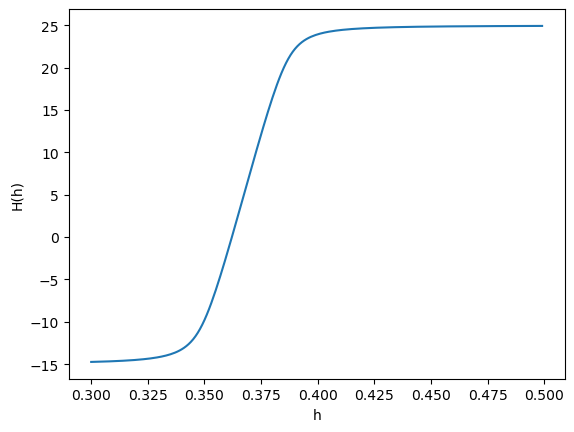

In [10]:
h = np.arange(0.3, 0.5, 0.001)

HArray = np.zeros(len(h))

for i in range(len(h)):
    HArray[i] = H(h[i])

plt.plot(h, HArray)
plt.xlabel('h')
plt.ylabel('H(h)')
plt.show()

In [11]:
# 保存数据为csv文件
import pandas as pd
import numpy as np

# 定义数据
data = {'h':h,'H':HArray}

# 转换为DataFrame
df = pd.DataFrame(data)

# 保存为csv文件
df.to_csv('../data/第一问数据.csv', index=False)

In [15]:
# 二分查找法求解问题一模型

import numpy as np

def binary_search(f, a, b,target, err=1e-6):
    assert a <= b
    mid = (a+b)/2
    if abs(b-a) > err:
        if f(mid) > target:
            return binary_search(f, a, mid, target, err)
        else:
            return binary_search(f, mid, b, target, err)
    else:
        return [mid, f(mid)]

ans = binary_search(H, 0, 2, target=18)
# 保存结果
ans = pd.DataFrame({'h':[ans[0]], 'H':[ans[1]]})
ans.to_csv('../data/第一问结果.csv', index=False)